# MScFE Capstone: CF-PDE vs BSM (Call-Only, 2-Month Study)
## Research Analysis on Call Options
This notebook performs a complete research analysis on **call options only**:
- Extract **only last 2 months** of SPX EOD call quotes from ThetaData (or use existing CSV)
- Split: **Month-1 calibration** (estimate α per DTE bucket) + **Month-2 test** (out-of-sample)
- Calibrate α using **call options only** for each DTE bucket
- Benchmark using **RMSE** (CF-PDE vs BSM) on call options
- Compare observed prices, BSM prices, and CF-PDE prices
- Remove arbitrageable quotes before calibration/testing

In [1]:
from pathlib import Path
import sys
import pandas as pd

# Ensure project root is on PYTHONPATH (works whether notebook is opened from notebooks/ or project root)
PROJECT_ROOT = Path().resolve()
if not (PROJECT_ROOT / 'pipeline.py').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

from pipeline import ProjectConfig, run_project_pipeline, fetch_last_months_from_thetadata

PROJECT_ROOT

PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6')

In [ ]:
# -------------------- USER SETTINGS --------------------
FETCH = False  # set True only if ThetaTerminal is running and you want fresh download
MONTHS = 2      #  last 2 months

DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
DATA_DIR.mkdir(exist_ok=True, parents=True)
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

WIDE_CSV = DATA_DIR / 'combined_options_data.csv'


In [3]:
if FETCH:
    # Requires ThetaTerminal v3 running locally.
    fetch_last_months_from_thetadata(out_csv=WIDE_CSV, months=MONTHS)
else:
    assert WIDE_CSV.exists(), f"Missing {WIDE_CSV}. Set FETCH=True or place the CSV there." 

WIDE_CSV

PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/data/combined_options_data.csv')

In [ ]:
# Project configuration for calibration and evaluation
cfg = ProjectConfig(
    total_months=2,
    calib_months=1,
    option_type='call',
    weight_mode='spread',
    sigma=0.16, r=0.035, q=0.021,
    min_moneyness=0.85,
    max_moneyness=1.15,
    otm_only=False,
    short_dte_max=30,
    I_short=65,
    J_short=180,
    I_base=26,
    J_base=60,
    max_calib_rows_per_bucket=180,
    max_test_rows_per_bucket=300,
    coarse_points=5,
    short_bucket_ensemble_runs=1,
    force_recalibrate=True,
    force_reprice_test=True,
    enable_plots=False,
)
cfg

ProjectConfig(total_months=2, calib_months=1, option_type='call', max_rel_spread=0.45, min_moneyness=0.85, max_moneyness=1.15, min_dte=7, max_dte=550, otm_only=False, sigma=0.16, r=0.035, q=0.021, I_base=26, J_base=60, I_short=65, J_short=180, short_dte_max=30, alpha_lo=0.1, alpha_hi=0.99, weight_mode='spread', coarse_points=5, max_calib_rows_per_bucket=180, short_bucket_ensemble_runs=1, max_test_rows_per_bucket=300, force_recalibrate=True, force_reprice_test=True, enable_plots=False)

In [ ]:
# Run end-to-end pipeline: calibration, pricing, error analysis, and plotting
out_paths = run_project_pipeline(
    wide_csv=WIDE_CSV,
    out_dir=RESULTS_DIR,
    cfg=cfg,
)
out_paths

{'prepared_long_2m': PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/prepared_long_2m.parquet'),
 'calibration_set_1m': PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/calibration_set_1m.parquet'),
 'test_set_1m': PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/test_set_1m.parquet'),
 'alpha_by_bucket': PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/calibration/alpha_by_bucket.csv'),
 'eval_rows_test': PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/test/eval_rows_test.parquet'),
 'metrics_rmse_by_bucket': PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/test/metrics_rmse_by_bucket.csv'),
 'metrics_rmse_daily': PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/test/metrics_rmse_daily.csv'),
 'metrics_rmse_overall': PosixPath('/Users/saurabh/Downloads/MScFE_Capstone_CFPDE_BSM 6/results/test/metrics_rmse_overall.csv'),
 'price_comp

In [6]:
# Load call-option price comparison outputs
price_by_bucket = pd.read_csv(out_paths['price_comparison_by_bucket'])
price_overall = pd.read_csv(out_paths['price_comparison_overall'])

print("\n=== Call-Option Price Comparison by Bucket ===\n")
print(price_by_bucket[['dte_bucket','n','OBS_mean','BSM_mean','CF_mean','MAE_BSM','MAE_CF','RMSE_BSM','RMSE_CF']].to_string(index=False))

print("\n=== Call-Option Price Comparison Overall ===\n")
print(price_overall.to_string(index=False))



=== Call-Option Price Comparison by Bucket ===

dte_bucket     n   OBS_mean   BSM_mean    CF_mean    MAE_BSM    MAE_CF   RMSE_BSM   RMSE_CF
  12m_plus 300.0 689.483000 560.437812 665.033228 130.392903 33.171286 152.450147 38.729939
     1m_2m 300.0 179.454667 177.551911 176.948166  20.373859 20.120866  23.723410 23.893854
     1w_2w 300.0 106.674833 112.333481 102.400490  10.614903  8.385183  13.002282 10.116946
     2m_3m 300.0 240.454000 229.030274 222.454537  24.962071 20.362305  29.464486 25.837329
     2w_1m 300.0 133.073500 135.628474 109.664221  15.637215 23.936549  18.488213 29.493362
     3m_6m 300.0 304.704167 279.642445 286.822113  35.541056 23.547469  44.625028 28.488083
     6m_9m 300.0 502.771167 438.012766 480.413941  76.359612 36.682753  93.955637 40.957053
    9m_12m 300.0 621.538833 520.886444 599.260019 104.550270 34.617090 125.490770 39.143363

=== Call-Option Price Comparison Overall ===

     n   OBS_mean   BSM_mean    CF_mean  BIAS_BSM    BIAS_CF   MAE_BSM    MA

In [ ]:
# Detailed sample-level comparison with error metrics (calls only)
eval_rows = pd.read_parquet(out_paths['eval_rows_test'])
detailed = eval_rows[['dte_bucket', 'MID', 'P_BSM', 'P_CF', 'ERR_BSM', 'ERR_CF']].copy()
detailed.columns = ['bucket', 'Observed_Price', 'BSM_Price', 'CF_Price', 'BSM_Error', 'CF_Error']

den = detailed['Observed_Price'].replace(0, pd.NA)
detailed['BSM_Pct_Error'] = (detailed['BSM_Error'] / den * 100).astype('float64')
detailed['CF_Pct_Error'] = (detailed['CF_Error'] / den * 100).astype('float64')

print("\n=== Sample-Level Call Price Comparison (First 20 rows) ===\n")
print(detailed.head(20).to_string(index=False))

error_stats = eval_rows.groupby('dte_bucket').agg(
    n=('contract_id','count'),
    BSM_Mean_Error=('ERR_BSM','mean'),
    BSM_Std_Error=('ERR_BSM','std'),
    CF_Mean_Error=('ERR_CF','mean'),
    CF_Std_Error=('ERR_CF','std'),
).reset_index().sort_values('dte_bucket')

print("\n=== Error Statistics by Bucket (Calls) ===\n")
print(error_stats.to_string(index=False))

detailed_csv = RESULTS_DIR / 'test' / 'detailed_price_comparison_calls.csv'
error_stats_csv = RESULTS_DIR / 'test' / 'error_statistics_by_bucket_calls.csv'
detailed_csv.parent.mkdir(parents=True, exist_ok=True)
detailed.to_csv(detailed_csv, index=False)
error_stats.to_csv(error_stats_csv, index=False)
print(f'Saved detailed comparison to: {detailed_csv}')
print(f'Saved error statistics to: {error_stats_csv}')



=== Sample-Level Call Price Comparison (First 20 rows) ===

  bucket  Observed_Price   BSM_Price    CF_Price   BSM_Error   CF_Error  BSM_Pct_Error  CF_Pct_Error
12m_plus          416.30  348.287222  391.468029  -68.012778 -24.831971     -16.337444     -5.964922
12m_plus          496.70  390.491360  463.759589 -106.208640 -32.940411     -21.382855     -6.631852
12m_plus          821.40  636.135293  789.589430 -185.264707 -31.810570     -22.554749     -3.872726
12m_plus          501.05  396.814508  459.554188 -104.235492 -41.495812     -20.803411     -8.281771
12m_plus          160.25  167.806483  181.659357    7.556483  21.409357       4.715434     13.359973
12m_plus          183.60  194.083480  212.861422   10.483480  29.261422       5.709956     15.937594
12m_plus         1166.00  938.071718 1113.923888 -227.928282 -52.076112     -19.547880     -4.466219
12m_plus         1362.00 1143.479781 1348.032250 -218.520219 -13.967750     -16.044069     -1.025532
12m_plus          843.75  650.

✓ Saved: price_rmse_comparison_by_bucket.png


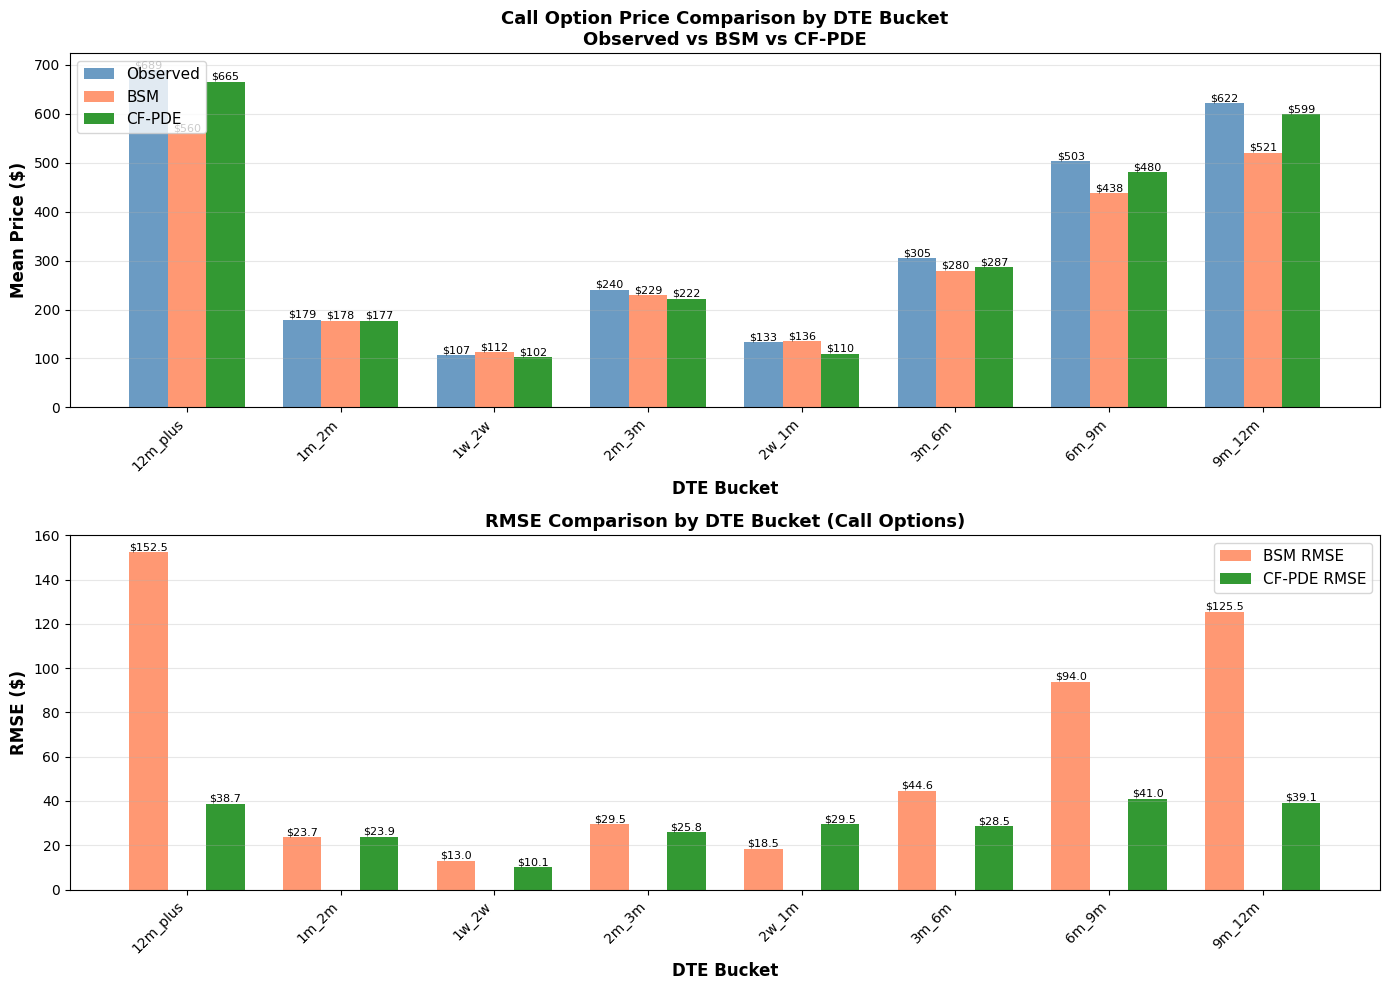

In [ ]:
# Price comparison by DTE bucket
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Mean prices by DTE bucket
ax1 = axes[0]
buckets = price_by_bucket['dte_bucket'].astype(str)
x = np.arange(len(buckets))
width = 0.25

bars1 = ax1.bar(x - width, price_by_bucket['OBS_mean'], width, label='Observed', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x, price_by_bucket['BSM_mean'], width, label='BSM', alpha=0.8, color='coral')
bars3 = ax1.bar(x + width, price_by_bucket['CF_mean'], width, label='CF-PDE', alpha=0.8, color='green')

ax1.set_xlabel('DTE Bucket', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Price ($)', fontsize=12, fontweight='bold')
ax1.set_title('Call Option Price Comparison by DTE Bucket\nObserved vs BSM vs CF-PDE', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(buckets, rotation=45, ha='right')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.0f}', ha='center', va='bottom', fontsize=8)

# Plot 2: RMSE comparison by bucket
ax2 = axes[1]
x = np.arange(len(buckets))
bars1 = ax2.bar(x - width, price_by_bucket['RMSE_BSM'], width, label='BSM RMSE', alpha=0.8, color='coral')
bars2 = ax2.bar(x + width, price_by_bucket['RMSE_CF'], width, label='CF-PDE RMSE', alpha=0.8, color='green')

ax2.set_xlabel('DTE Bucket', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE ($)', fontsize=12, fontweight='bold')
ax2.set_title('RMSE Comparison by DTE Bucket (Call Options)', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(buckets, rotation=45, ha='right')
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'plots' / 'price_rmse_comparison_by_bucket.png', dpi=300, bbox_inches='tight')
print("Saved: price_rmse_comparison_by_bucket.png")
plt.show()

✓ Saved: daily_price_evolution_test_month.png


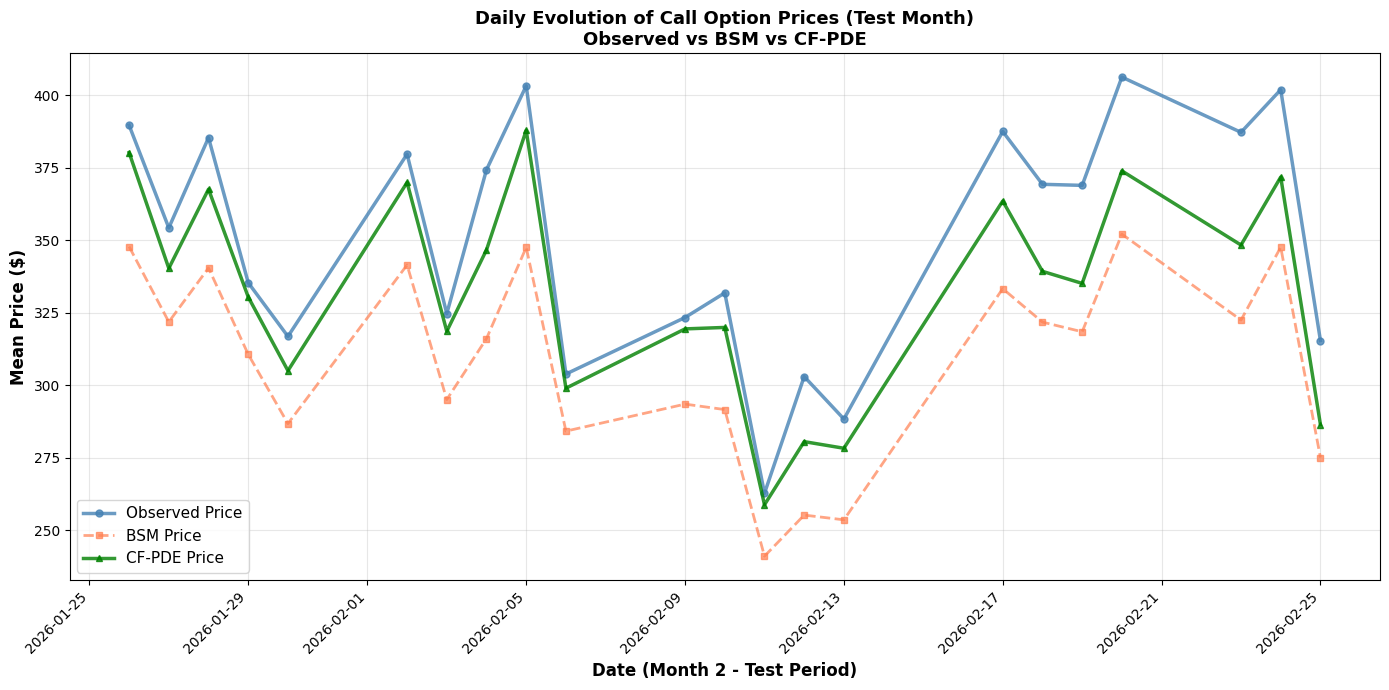

In [ ]:
# Daily price evolution over test period
price_daily = pd.read_csv(out_paths['price_comparison_daily'])
price_daily['QUOTE_DATE'] = pd.to_datetime(price_daily['QUOTE_DATE'])

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(price_daily['QUOTE_DATE'], price_daily['OBS_mean'], marker='o', linewidth=2.5, 
        markersize=5, label='Observed Price', color='steelblue', alpha=0.8)
ax.plot(price_daily['QUOTE_DATE'], price_daily['BSM_mean'], marker='s', linewidth=2, 
        markersize=4, label='BSM Price', color='coral', alpha=0.7, linestyle='--')
ax.plot(price_daily['QUOTE_DATE'], price_daily['CF_mean'], marker='^', linewidth=2.5, 
        markersize=4, label='CF-PDE Price', color='green', alpha=0.8)

ax.set_xlabel('Date (Month 2 - Test Period)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Price ($)', fontsize=12, fontweight='bold')
ax.set_title('Daily Evolution of Call Option Prices (Test Month)\nObserved vs BSM vs CF-PDE', 
             fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'plots' / 'daily_price_evolution_test_month.png', dpi=300, bbox_inches='tight')
print("Saved: daily_price_evolution_test_month.png")
plt.show()

✓ Saved: daily_rmse_evolution.png


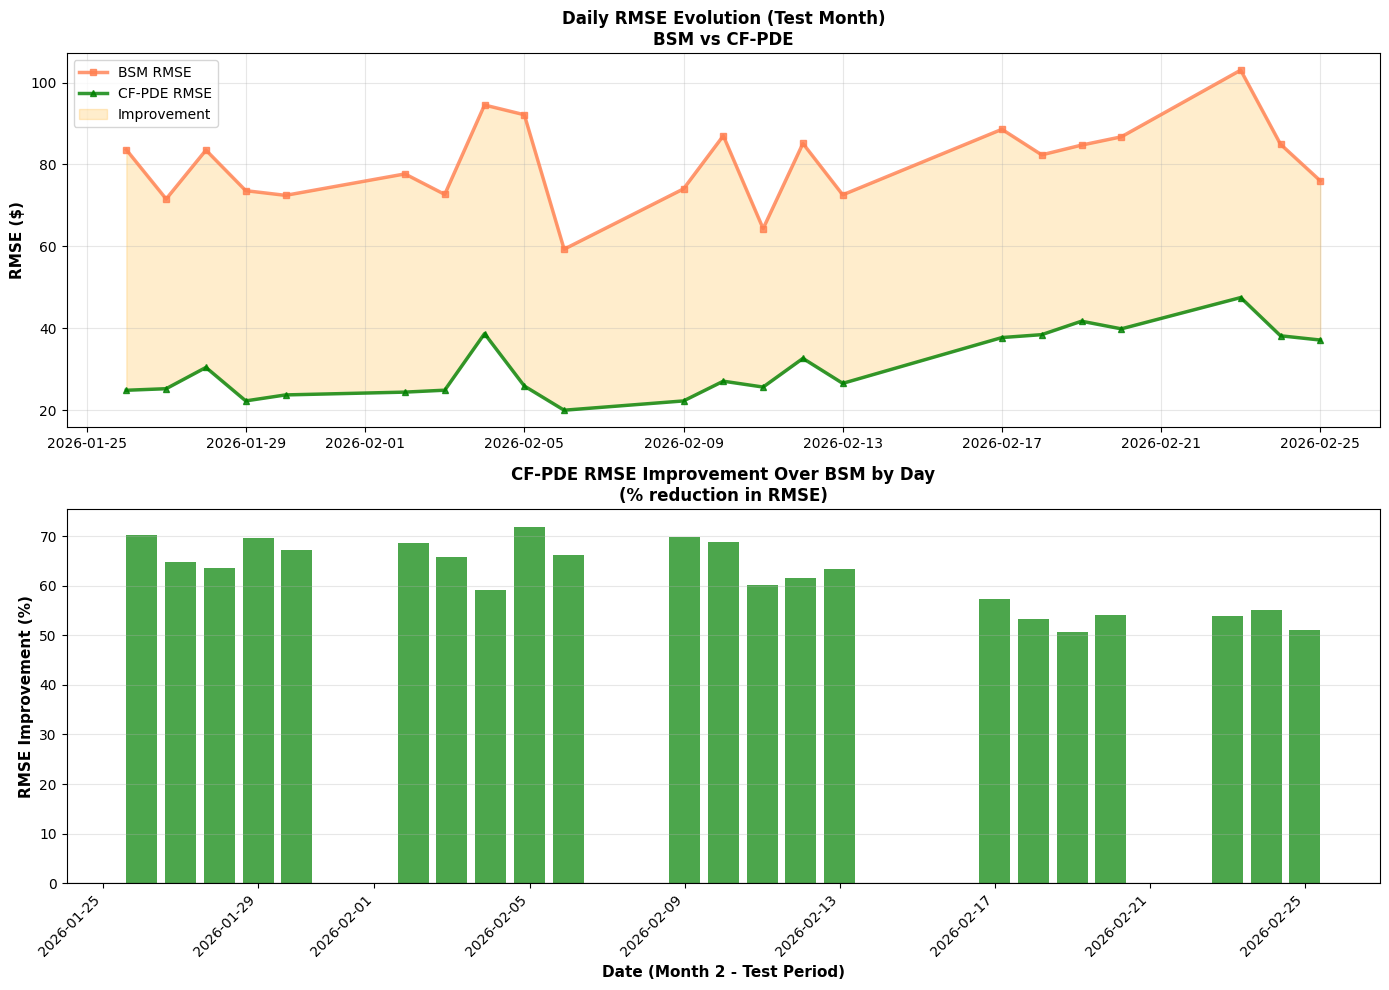

In [9]:
# Daily RMSE and error evolution
metrics_daily = pd.read_csv(out_paths['metrics_rmse_daily'])
metrics_daily['QUOTE_DATE'] = pd.to_datetime(metrics_daily['QUOTE_DATE'])

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Daily RMSE comparison
ax1 = axes[0]
ax1.plot(metrics_daily['QUOTE_DATE'], metrics_daily['RMSE_BSM'], marker='s', linewidth=2.5, 
         markersize=5, label='BSM RMSE', color='coral', alpha=0.8)
ax1.plot(metrics_daily['QUOTE_DATE'], metrics_daily['RMSE_CF'], marker='^', linewidth=2.5, 
         markersize=5, label='CF-PDE RMSE', color='green', alpha=0.8)
ax1.fill_between(metrics_daily['QUOTE_DATE'], metrics_daily['RMSE_BSM'], 
                 metrics_daily['RMSE_CF'], alpha=0.2, color='orange', label='Improvement')

ax1.set_ylabel('RMSE ($)', fontsize=11, fontweight='bold')
ax1.set_title('Daily RMSE Evolution (Test Month)\nBSM vs CF-PDE', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

# Plot 2: Daily improvement percentage
ax2 = axes[1]
improvement_pct = (metrics_daily['RMSE_BSM'] - metrics_daily['RMSE_CF']) / metrics_daily['RMSE_BSM'] * 100
colors = ['green' if x > 0 else 'red' for x in improvement_pct]
bars = ax2.bar(metrics_daily['QUOTE_DATE'], improvement_pct, color=colors, alpha=0.7)

ax2.set_xlabel('Date (Month 2 - Test Period)', fontsize=11, fontweight='bold')
ax2.set_ylabel('RMSE Improvement (%)', fontsize=11, fontweight='bold')
ax2.set_title('CF-PDE RMSE Improvement Over BSM by Day\n(% reduction in RMSE)', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='y', alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'plots' / 'daily_rmse_evolution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: daily_rmse_evolution.png")
plt.show()

✓ Saved: scatter_observed_vs_predicted.png


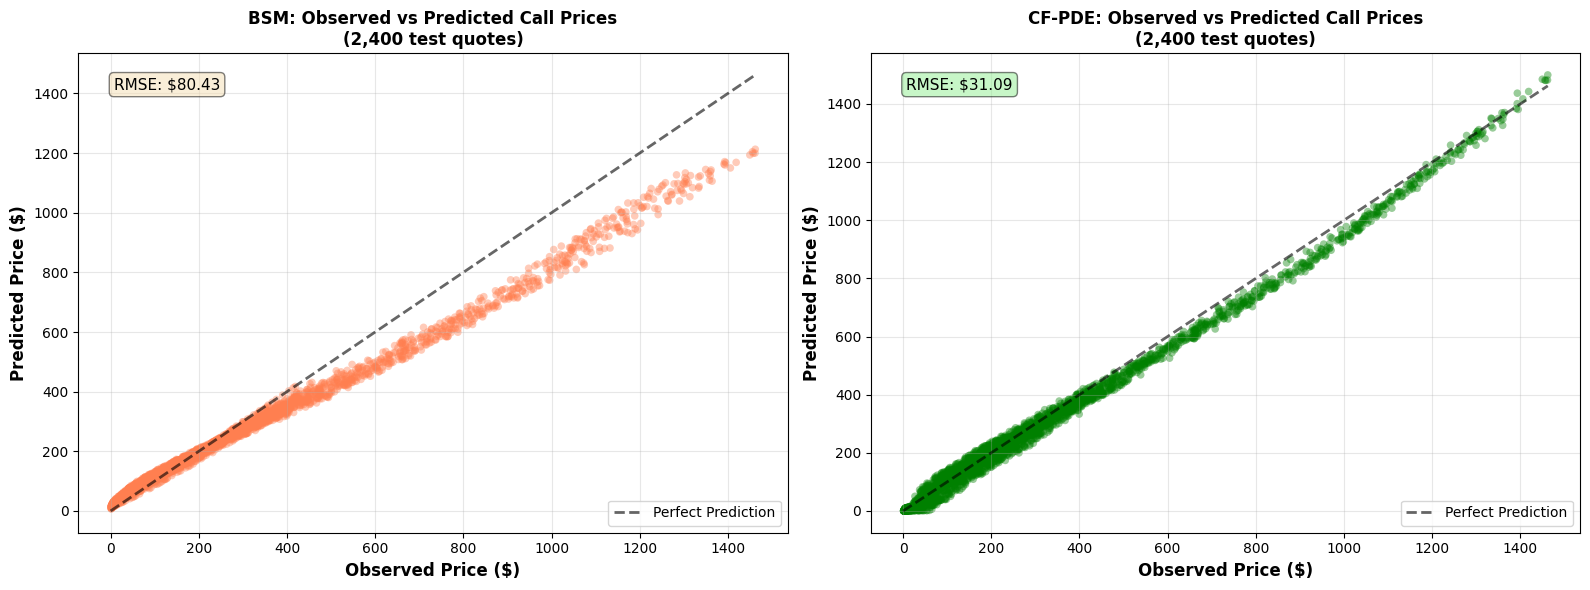

In [10]:
# Observed vs Predicted Prices - Scatter plots by model
eval_rows = pd.read_parquet(out_paths['eval_rows_test'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BSM scatter plot
ax1 = axes[0]
ax1.scatter(eval_rows['MID'], eval_rows['P_BSM'], alpha=0.4, s=30, color='coral', edgecolors='none')
# Add perfect prediction line
max_price = max(eval_rows['MID'].max(), eval_rows['P_BSM'].max())
ax1.plot([0, max_price], [0, max_price], 'k--', linewidth=2, label='Perfect Prediction', alpha=0.6)
ax1.set_xlabel('Observed Price ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Price ($)', fontsize=12, fontweight='bold')
ax1.set_title('BSM: Observed vs Predicted Call Prices\n(2,400 test quotes)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
rmse_bsm = np.sqrt(np.mean((eval_rows['MID'] - eval_rows['P_BSM'])**2))
ax1.text(0.05, 0.95, f'RMSE: ${rmse_bsm:.2f}', transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# CF-PDE scatter plot
ax2 = axes[1]
ax2.scatter(eval_rows['MID'], eval_rows['P_CF'], alpha=0.4, s=30, color='green', edgecolors='none')
ax2.plot([0, max_price], [0, max_price], 'k--', linewidth=2, label='Perfect Prediction', alpha=0.6)
ax2.set_xlabel('Observed Price ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predicted Price ($)', fontsize=12, fontweight='bold')
ax2.set_title('CF-PDE: Observed vs Predicted Call Prices\n(2,400 test quotes)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
rmse_cf = np.sqrt(np.mean((eval_rows['MID'] - eval_rows['P_CF'])**2))
ax2.text(0.05, 0.95, f'RMSE: ${rmse_cf:.2f}', transform=ax2.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'plots' / 'scatter_observed_vs_predicted.png', dpi=300, bbox_inches='tight')
print("✓ Saved: scatter_observed_vs_predicted.png")
plt.show()

✓ Saved: alpha_and_error_analysis.png


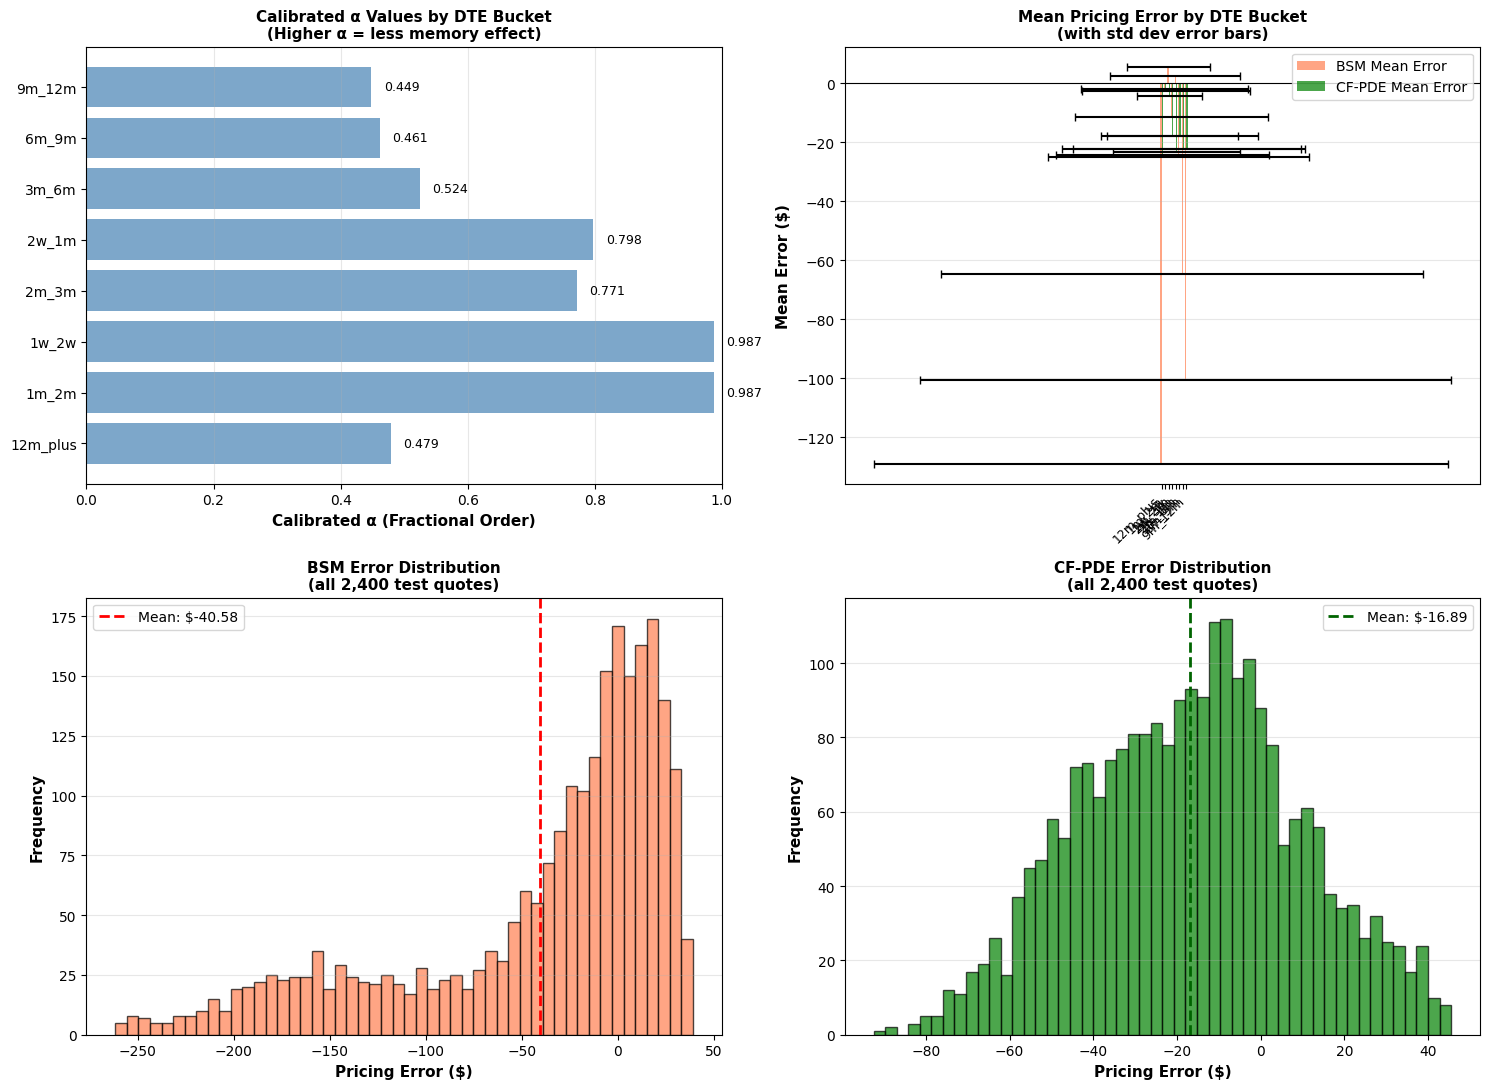

In [ ]:
# Alpha values and error distributions by bucket
alpha_data = pd.read_csv(out_paths['alpha_by_bucket'])

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

# Plot 1: Calibrated Alpha by DTE bucket
ax1 = axes[0, 0]
bars = ax1.barh(range(len(alpha_data)), alpha_data['alpha'], color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(alpha_data)))
ax1.set_yticklabels(alpha_data['dte_bucket'], fontsize=10)
ax1.set_xlabel('Calibrated α (Fractional Order)', fontsize=11, fontweight='bold')
ax1.set_title('Calibrated α Values by DTE Bucket', fontsize=11, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim([0, 1.0])

# Add value labels
for i, (bar, val) in enumerate(zip(bars, alpha_data['alpha'])):
    ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', fontsize=9)

# Plot 2: Error by bucket - BSM vs CF
ax2 = axes[0, 1]
error_stats = eval_rows.groupby('dte_bucket').agg({
    'ERR_BSM': ['mean', 'std'],
    'ERR_CF': ['mean', 'std']
}).reset_index()
error_stats.columns = ['dte_bucket', 'BSM_mean', 'BSM_std', 'CF_mean', 'CF_std']

x = np.arange(len(error_stats))
width = 0.35
ax2.bar(x - width/2, error_stats['BSM_mean'], width, label='BSM Mean Error', 
        color='coral', alpha=0.7, xerr=error_stats['BSM_std'], capsize=3)
ax2.bar(x + width/2, error_stats['CF_mean'], width, label='CF-PDE Mean Error', 
        color='green', alpha=0.7, xerr=error_stats['CF_std'], capsize=3)
ax2.set_xticks(x)
ax2.set_xticklabels(error_stats['dte_bucket'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Mean Error ($)', fontsize=11, fontweight='bold')
ax2.set_title('Mean Pricing Error by DTE Bucket', fontsize=11, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Error distribution histogram - BSM
ax3 = axes[1, 0]
ax3.hist(eval_rows['ERR_BSM'], bins=50, color='coral', alpha=0.7, edgecolor='black')
ax3.axvline(eval_rows['ERR_BSM'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${eval_rows["ERR_BSM"].mean():.2f}')
ax3.set_xlabel('Pricing Error ($)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('BSM Error Distribution\n(all 2,400 test quotes)', fontsize=11, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Error distribution histogram - CF
ax4 = axes[1, 1]
ax4.hist(eval_rows['ERR_CF'], bins=50, color='green', alpha=0.7, edgecolor='black')
ax4.axvline(eval_rows['ERR_CF'].mean(), color='darkgreen', linestyle='--', linewidth=2, 
            label=f'Mean: ${eval_rows["ERR_CF"].mean():.2f}')
ax4.set_xlabel('Pricing Error ($)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('CF-PDE Error Distribution\n(all 2,400 test quotes)', fontsize=11, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'plots' / 'alpha_and_error_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: alpha_and_error_analysis.png")
plt.show()

✓ Saved: mae_mape_accuracy_by_bucket.png


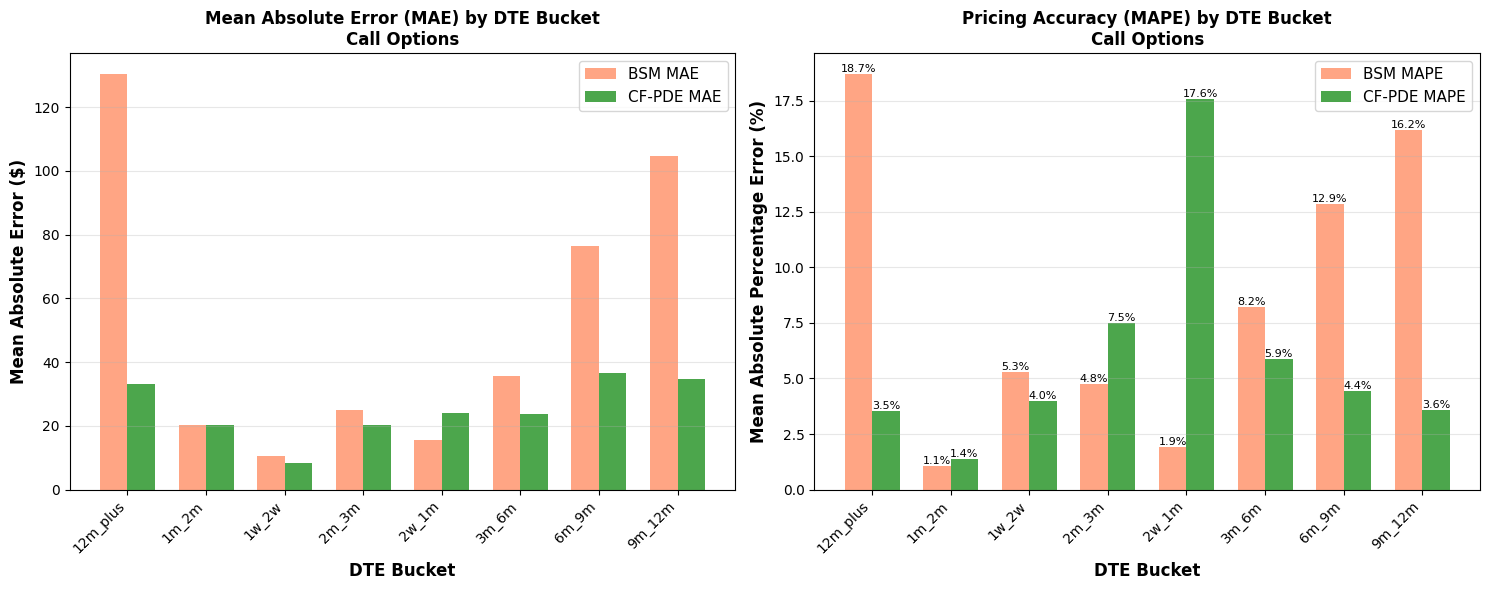

In [ ]:
# Pricing accuracy analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Mean Absolute Error (MAE) comparison
ax1 = axes[0]
buckets = price_by_bucket['dte_bucket'].astype(str)
x = np.arange(len(buckets))
width = 0.35

bars1 = ax1.bar(x - width/2, price_by_bucket['MAE_BSM'], width, label='BSM MAE', 
                color='coral', alpha=0.7)
bars2 = ax1.bar(x + width/2, price_by_bucket['MAE_CF'], width, label='CF-PDE MAE', 
                color='green', alpha=0.7)

ax1.set_xlabel('DTE Bucket', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Absolute Error ($)', fontsize=12, fontweight='bold')
ax1.set_title('Mean Absolute Error (MAE) by DTE Bucket\nCall Options', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(buckets, rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Pricing accuracy - MAPE (Mean Absolute Percentage Error)
ax2 = axes[1]
# Calculate MAPE
mape_bsm = np.abs((price_by_bucket['OBS_mean'] - price_by_bucket['BSM_mean']) / price_by_bucket['OBS_mean'] * 100)
mape_cf = np.abs((price_by_bucket['OBS_mean'] - price_by_bucket['CF_mean']) / price_by_bucket['OBS_mean'] * 100)

bars1 = ax2.bar(x - width/2, mape_bsm, width, label='BSM MAPE', color='coral', alpha=0.7)
bars2 = ax2.bar(x + width/2, mape_cf, width, label='CF-PDE MAPE', color='green', alpha=0.7)

ax2.set_xlabel('DTE Bucket', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Absolute Percentage Error (%)', fontsize=12, fontweight='bold')
ax2.set_title('Pricing Accuracy (MAPE) by DTE Bucket\nCall Options', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(buckets, rotation=45, ha='right')
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'plots' / 'mae_mape_accuracy_by_bucket.png', dpi=300, bbox_inches='tight')
print("Saved: mae_mape_accuracy_by_bucket.png")
plt.show()

✓ Saved: price_heatmaps_by_date_dte.png


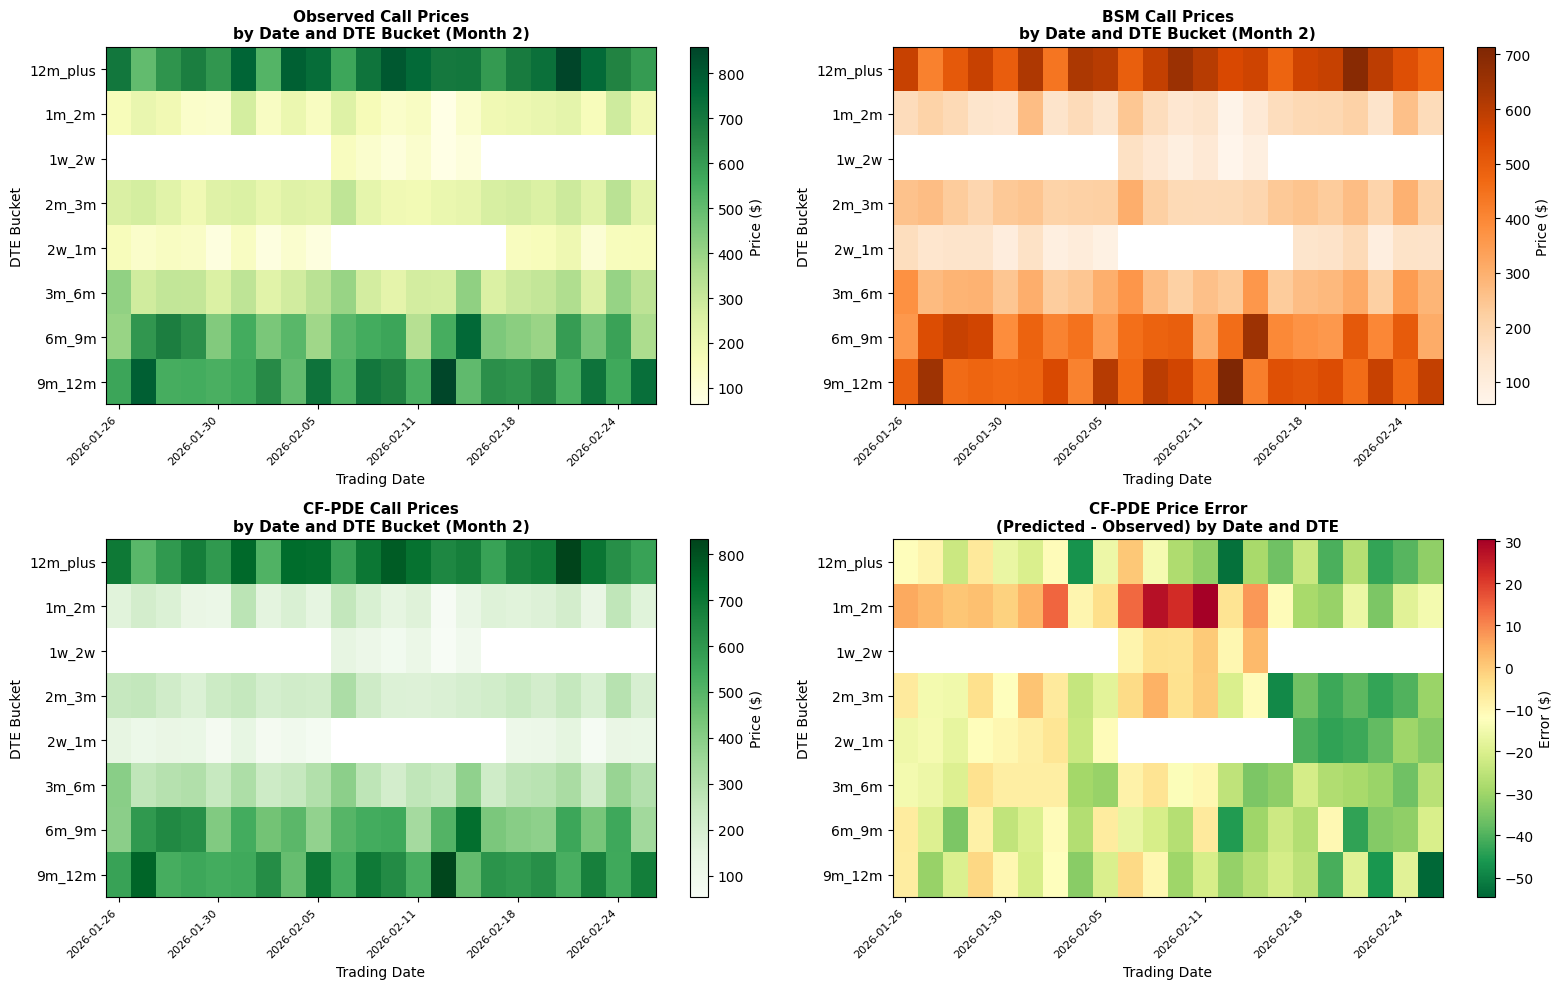

In [ ]:
# Price heatmaps by date and DTE bucket
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Prepare data for heatmaps (price by date and DTE bucket)
eval_by_date_bucket = eval_rows.groupby(['QUOTE_DATE', 'dte_bucket']).agg({
    'MID': 'mean',
    'P_BSM': 'mean',
    'P_CF': 'mean'
}).reset_index()

eval_by_date_bucket['QUOTE_DATE'] = pd.to_datetime(eval_by_date_bucket['QUOTE_DATE'])

# Separate data for each metric
pivot_obs = eval_by_date_bucket.pivot_table(values='MID', index='dte_bucket', columns='QUOTE_DATE')
pivot_bsm = eval_by_date_bucket.pivot_table(values='P_BSM', index='dte_bucket', columns='QUOTE_DATE')
pivot_cf = eval_by_date_bucket.pivot_table(values='P_CF', index='dte_bucket', columns='QUOTE_DATE')

# Plot 1: Observed prices heatmap
im1 = axes[0, 0].imshow(pivot_obs.values, cmap='YlGn', aspect='auto')
axes[0, 0].set_yticks(range(len(pivot_obs.index)))
axes[0, 0].set_yticklabels(pivot_obs.index)
axes[0, 0].set_title('Observed Call Prices\nby Date and DTE Bucket (Month 2)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Trading Date', fontsize=10)
axes[0, 0].set_ylabel('DTE Bucket', fontsize=10)
# Simplify x-axis labels
x_labels = [str(pivot_obs.columns[i])[:10] for i in range(0, len(pivot_obs.columns), max(1, len(pivot_obs.columns)//5))]
x_positions = range(0, len(pivot_obs.columns), max(1, len(pivot_obs.columns)//5))
axes[0, 0].set_xticks(x_positions)
axes[0, 0].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
plt.colorbar(im1, ax=axes[0, 0], label='Price ($)')

# Plot 2: BSM prices heatmap
im2 = axes[0, 1].imshow(pivot_bsm.values, cmap='Oranges', aspect='auto')
axes[0, 1].set_yticks(range(len(pivot_bsm.index)))
axes[0, 1].set_yticklabels(pivot_bsm.index)
axes[0, 1].set_title('BSM Call Prices\nby Date and DTE Bucket (Month 2)', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Trading Date', fontsize=10)
axes[0, 1].set_ylabel('DTE Bucket', fontsize=10)
axes[0, 1].set_xticks(x_positions)
axes[0, 1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
plt.colorbar(im2, ax=axes[0, 1], label='Price ($)')

# Plot 3: CF-PDE prices heatmap
im3 = axes[1, 0].imshow(pivot_cf.values, cmap='Greens', aspect='auto')
axes[1, 0].set_yticks(range(len(pivot_cf.index)))
axes[1, 0].set_yticklabels(pivot_cf.index)
axes[1, 0].set_title('CF-PDE Call Prices\nby Date and DTE Bucket (Month 2)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Trading Date', fontsize=10)
axes[1, 0].set_ylabel('DTE Bucket', fontsize=10)
axes[1, 0].set_xticks(x_positions)
axes[1, 0].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
plt.colorbar(im3, ax=axes[1, 0], label='Price ($)')

# Plot 4: Price differences (CF vs Observed)
pivot_diff = pivot_cf - pivot_obs
im4 = axes[1, 1].imshow(pivot_diff.values, cmap='RdYlGn_r', aspect='auto')
axes[1, 1].set_yticks(range(len(pivot_diff.index)))
axes[1, 1].set_yticklabels(pivot_diff.index)
axes[1, 1].set_title('CF-PDE Price Error\n(Predicted - Observed) by Date and DTE', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Trading Date', fontsize=10)
axes[1, 1].set_ylabel('DTE Bucket', fontsize=10)
axes[1, 1].set_xticks(x_positions)
axes[1, 1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
plt.colorbar(im4, ax=axes[1, 1], label='Error ($)')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'plots' / 'price_heatmaps_by_date_dte.png', dpi=300, bbox_inches='tight')
print("Saved: price_heatmaps_by_date_dte.png")
plt.show()

## Key Outputs (Call Options Only)
All results below are based on call options exclusively:
- `results/calibration/alpha_by_bucket.csv` - Calibrated α per DTE bucket (calls only)
- `results/test/metrics_rmse_by_bucket.csv` - RMSE comparison by bucket and metric (calls)
- `results/test/price_comparison_by_bucket.csv` - Mean observed, BSM, and CF prices by bucket (calls)
- `results/test/price_comparison_overall.csv` - Aggregate price statistics (calls only)
- `results/test/metrics_rmse_overall.csv` - Overall RMSE summary (calls)
- `results/test/detailed_price_comparison_calls.csv` - Sample-level price comparison
- `results/test/error_statistics_by_bucket_calls.csv` - Error analysis by bucket
- `results/plots/price_means_by_bucket_test.png` - Visual comparison of mean prices (calls)
- `results/plots/rmse_improvement_by_bucket_test.png` - RMSE improvement visualization (calls)